### IMDB Benchmarking
This notebook trains and evaluates different language representations and classification models on the IMDB movie review dataset. The dataset contains 50,000 highily polarized reviews of movies which is labeled as positive or negative. State of the art models currently have an accuracy of ~95 %, according to [nlpprogress.com](http://nlpprogress.com/english/sentiment_analysis.html).

In [6]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.utils import parallel_backend
from pathlib import Path
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.dummy import DummyClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#### Load the IMDB data as raw text and labels

In [7]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

imdb_path = ONEDRIVE_PATH / 'Benchmark Datasets/IMDB Dataset.csv'
imdb = pd.read_csv(imdb_path)
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Format the data with tf-idf
Remove line breaks and vectorize the text. The size of hte vocabulary is roughly 100,000, but we'll limit it to a lower number for computational purposes. The vectorizer is fitted to the training data, so it doesn't benefit from knowing words not present in the training data. Shouldn't really be any difference, but I guess it's good practice. 

In [8]:
# Remove single line breaks (<br />) and convert to lower case
for i in trange(len(imdb)):
    imdb.iloc[i]['review'] = imdb.iloc[i]['review'].replace('<br />', ' ').lower()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:09<00:00, 5239.04it/s]


In [9]:
# Create a matrix with the frequency of a word in each day.
count_vec = CountVectorizer(max_features=10000)
count_vec.fit(imdb.iloc[:25000]['review'])

x_train_count = count_vec.transform(imdb.iloc[:25000]['review'])
x_test_count = count_vec.transform(imdb.iloc[25000:]['review'])

# Create a matrix with the tfidf representation of the text
tfidf_vec = TfidfTransformer()
tfidf_vec.fit(x_train_count)
x_train_tfidf = tfidf_vec.transform(x_train_count)
x_test_tfidf = tfidf_vec.transform(x_test_count)

# Assign labels to variables for convenience
y_train = np.zeros((25000))
y_test = np.zeros((25000))
for i in trange(len(y_train)): 
    if imdb.iloc[i]['sentiment'] == 'positive':
        y_train[i] = 1
    if imdb.iloc[25000 + i]['sentiment'] == 'positive':
        y_test[i] = 1

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:04<00:00, 5479.09it/s]


In [10]:
# Sanity check of shapes and label balance
print("Shape of training data:",x_train_tfidf.shape)
print("Shape of test data:",x_test_tfidf.shape)
print("Ratio positive reviews in training data:",np.sum(y_train) / len(y_train))
print("Ratio positive reviews in test data:",np.sum(y_test) / len(y_test))

Shape of training data: (25000, 10000)
Shape of test data: (25000, 10000)
Ratio positive reviews in training data: 0.49896
Ratio positive reviews in test data: 0.50104


In [131]:
def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",np.sum(y_test_preds == y_test) / len(y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs TF-IDF/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs TF-IDF/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test_tfidf))
    y_train_pred = np.round(model.predict(x_train_tfidf))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs TF-IDF/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Train accuracy:",sum((np.transpose(y_train_pred) == y_train)[0]) / len(y_train))
    print("Test accuracy:",sum((np.transpose(y_test_pred) == y_test)[0]) / len(y_test))

In [133]:
# Create a matrix with the frequency of a word in each day.
def eval_vocsize(size):
    count_vec = CountVectorizer(max_features=size)
    count_vec.fit(imdb.iloc[:25000]['review'])

    x_train_count = count_vec.transform(imdb.iloc[:25000]['review'])
    x_test_count = count_vec.transform(imdb.iloc[25000:]['review'])

    # Create a matrix with the tfidf representation of the text
    tfidf_vec = TfidfTransformer()
    tfidf_vec.fit(x_train_count)
    x_train_tfidf = tfidf_vec.transform(x_train_count)
    x_test_tfidf = tfidf_vec.transform(x_test_count)
    
    # Logistic regression
    logreg = LogisticRegression(random_state=0).fit(x_train_tfidf, y_train)
    plot_results(logreg,x_test_tfidf, y_test,save=True,name='logreg')
    

Evaluating 500.
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84     12474
         1.0       0.84      0.85      0.84     12526

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Test accuracy: 0.84032


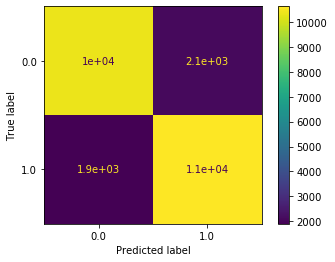

Evaluating 1000.
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86     12474
         1.0       0.86      0.87      0.86     12526

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Test accuracy: 0.86312


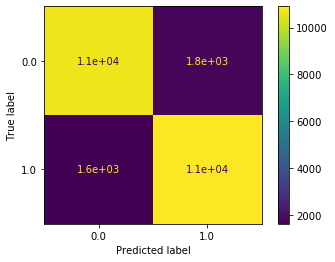

Evaluating 5000.
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.8876


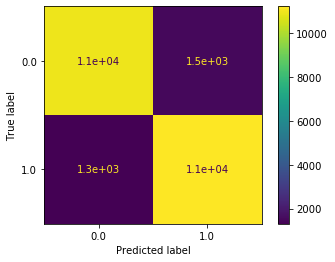

Evaluating 7500.


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.8886


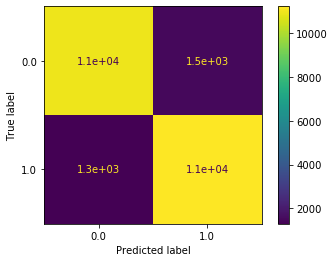

Evaluating 10000.
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.89072


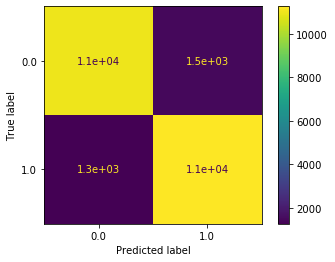

Evaluating 15000.
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.89      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.89164


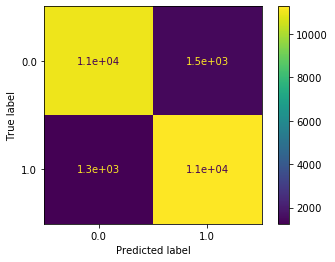

Evaluating 20000.
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.8914


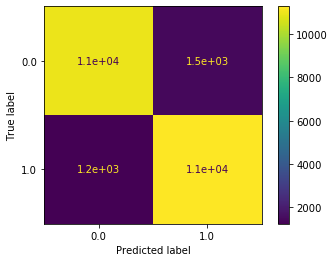

Evaluating 25000.
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.89152


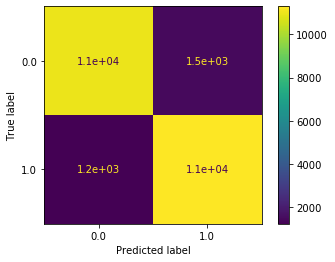

Evaluating 30000.


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.89176


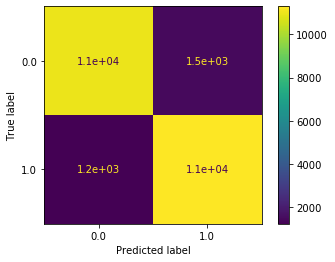

Evaluating 40000.
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.89136


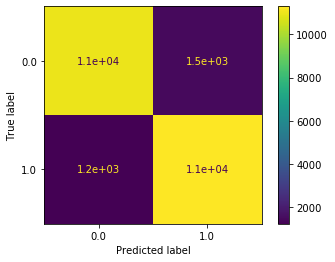

Evaluating 50000.
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.89156


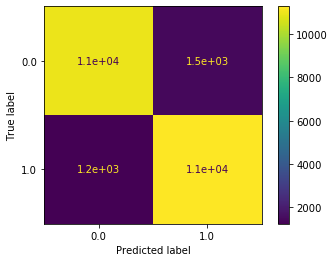

In [135]:
sizes = [500, 1000, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 40000, 50000]
for size in sizes: 
    print("Evaluating {}.".format(size))
    eval_vocsize(size)

### Logistic Regression with TF-IDF

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.88      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.89072


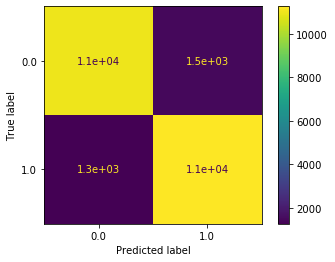

In [139]:
# Logistic regression
logreg = LogisticRegression(random_state=0).fit(x_train_tfidf, y_train)
plot_results(logreg,x_test_tfidf, y_test,save=True,name='logreg')

### Support Vector Machine with TF-IDF

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     12474
         1.0       0.89      0.90      0.90     12526

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

Test accuracy: 0.8954


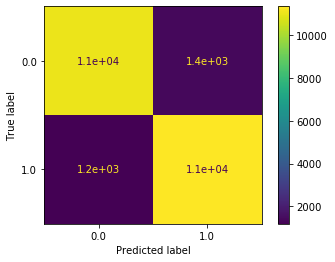

In [13]:
svm_clf = svm.SVC().fit(x_train_tfidf, y_train)
plot_results(svm_clf, x_test_tfidf, y_test,save=True,name='svm')

### Random Forest with TF-IDF

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 91.3min finished


Best: 0.852200 using {'max_depth': None, 'n_estimators': 3000}
0.851480 (0.001682) with: {'max_depth': None, 'n_estimators': 2000}
0.851600 (0.002001) with: {'max_depth': None, 'n_estimators': 2500}
0.852200 (0.002326) with: {'max_depth': None, 'n_estimators': 3000}
0.851280 (0.002081) with: {'max_depth': None, 'n_estimators': 3500}
0.851760 (0.001029) with: {'max_depth': None, 'n_estimators': 4000}
0.819720 (0.004297) with: {'max_depth': 3, 'n_estimators': 2000}
0.821280 (0.003199) with: {'max_depth': 3, 'n_estimators': 2500}
0.821040 (0.005080) with: {'max_depth': 3, 'n_estimators': 3000}
0.819560 (0.004959) with: {'max_depth': 3, 'n_estimators': 3500}
0.819680 (0.005833) with: {'max_depth': 3, 'n_estimators': 4000}
0.823920 (0.004498) with: {'max_depth': 5, 'n_estimators': 2000}
0.822480 (0.004296) with: {'max_depth': 5, 'n_estimators': 2500}
0.824200 (0.004022) with: {'max_depth': 5, 'n_estimators': 3000}
0.824320 (0.003283) with: {'max_depth': 5, 'n_estimators': 3500}
0.823720 (0.

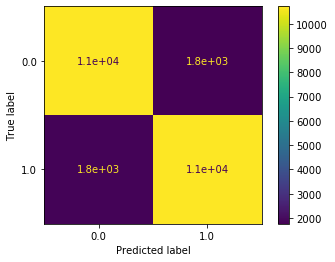

In [11]:
# Random Forest

rf_param_grid = dict(max_depth=[None, 3, 5, 10],
                  n_estimators=[2000, 2500, 3000, 3500, 4000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=1, 
                       cv=3, 
                       scoring='accuracy',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_tfidf, y_train)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_tfidf, y_train)
plot_results(randomforest,x_test_tfidf, y_test,save=True,name='rf_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Network

In [134]:
def create_model(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train_tfidf.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_tfidf.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

def randomize_params(params, n):
    test_params = []
    for i in range(n):
        temp_par = {}
        while True: 
            for par in params: 
                temp_par.update({par: np.random.choice(params[par])})
            if temp_par not in test_params: 
                test_params.append(temp_par)
                break
    return test_params

Since the dimensionality when using tf-idf is quite large, RandomizedSearchCV seems to work rather poorly. A simple implementation of the same method is made instead. 

In [135]:
n_tests = 20
# Define possible parameters 
possible_params = dict(batch_size = [4, 8],
                       nodes1 = [50, 100, 250, 500],
                       nodes2 = [0, 50, 100, 250, 500], # 0 implies only one hidden layer 
                       dropout_rate = [0.1, 0.3, 0.5],
                       learning_rate = [1e-3, 1e-4, 1e-5],
                       optimizer = ['RMSprop','Adam'])
test_params = randomize_params(possible_params, n_tests)


In [136]:
val_accs = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_tfidf, y_train,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    val_accs.append(max(history.history['val_acc']))
print("Best val acc:",max(val_accs))
print("For config: ",test_params[np.argmax(val_accs)])

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:56:11<00:00, 528.56s/it]

Best val acc: 0.89
For config:  {'nodes1': 250, 'nodes2': 100, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'RMSprop', 'batch_size': 8}


Train on 20000 samples, validate on 5000 samples
Epoch 1/10000
20000/20000 [==============================] - 77s 4ms/sample - loss: 0.4378 - acc: 0.8217 - val_loss: 0.3030 - val_acc: 0.8738
Epoch 2/10000
20000/20000 [==============================] - 76s 4ms/sample - loss: 0.2502 - acc: 0.8987 - val_loss: 0.2979 - val_acc: 0.8856
Epoch 3/10000
20000/20000 [==============================] - 75s 4ms/sample - loss: 0.2278 - acc: 0.9115 - val_loss: 0.3030 - val_acc: 0.8878
Epoch 4/10000
20000/20000 [==============================] - 76s 4ms/sample - loss: 0.2169 - acc: 0.9188 - val_loss: 0.3075 - val_acc: 0.8868
Epoch 5/10000
20000/20000 [==============================] - 76s 4ms/sample - loss: 0.2125 - acc: 0.9202 - val_loss: 0.3073 - val_acc: 0.8862
Epoch 6/10000
20000/20000 [==============================] - 77s 4ms/sample - loss: 0.2057 - acc: 0.9227 - val_loss: 0.3084 - val_acc: 0.8892
Epoch 7/10000
20000/20000 [==============================] - 76s 4ms/sample - loss: 0.2021 - acc: 0

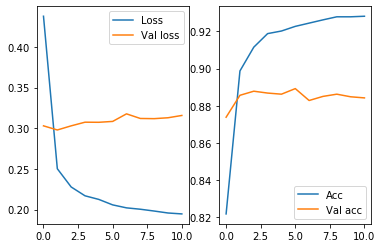

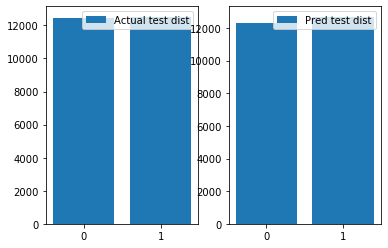

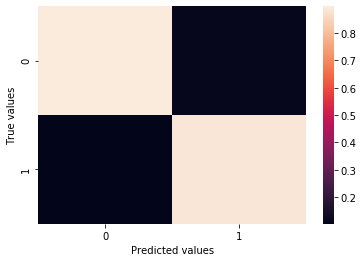

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     12474
         1.0       0.89      0.90      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Train accuracy: 0.92032
Test accuracy: 0.89176


In [137]:
# Fit a model with the best parameters 
best_params = test_params[np.argmax(val_accs)]
bs = best_params.pop('batch_size')
model = create_model(**best_params) 
best_params.update({'batch_size':bs})
history = model.fit(x_train_tfidf, y_train, 
                    epochs=10000,
                    validation_split=0.2,
                    batch_size=bs,
                    verbose=1,
                    callbacks=[EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)])


plot_results_nn(history, model,save=True,name='nn_n1{}_n2{}_dr{}_lr{}_opt{}'.format(best_params['nodes1'],
                                                                                    best_params['nodes2'],
                                                                                    best_params['dropout_rate'],
                                                                                    best_params['learning_rate'],
                                                                                    best_params['optimizer']))

## Results

The following results were achieved on the independent test set on the IMDB dataset. Note that only the 10000 most common words were included in the vocabulary, to reduce the dimensionality. 

| Model |  Test Accuracy (%)  | Hyperparameters |
| :----- | --------------- | --- | 
| Random Classifier | 49.5 | N/A |
| Logistic Regression | 89.1 | N/A |
| Linear Discriminant Analysis | 82.9 | N/A |
| __Support Vector Machine__ | __89.5__ | N/A |
| Random Forest | 85.6 | n_estimators=3000, max_depth=None |
| XGBoost | 87.2 | n_estimators=1000 |
| Multi Layer Perceptron | 89.1 | batch_size=8,depth=2,dropout_rate=0.2,nodes=250 |

It is interesting to note that the simpler TF-IDF-approach gievs a significantly higher accuracy than the GloVe-embeddings. 

For comparison, the table below displays state-of-the-art models for the IMDB classification task. 

| Model |	Accuracy (%) |	Paper / Source|
|:----- | ---------- | -------------- |  
| XLNet (Yang et al., 2019) |	__96.21__ |	XLNet: Generalized Autoregressive Pretraining for Language Understanding|
| BERT_large+ITPT (Sun et al., 2019) 	|95.79 |	How to Fine-Tune BERT for Text Classification?|
| BERT_base+ITPT (Sun et al., 2019) |	95.63 |	How to Fine-Tune BERT for Text Classification?|
| ULMFiT (Howard and Ruder, 2018) |	95.4 |	Universal Language Model Fine-tuning for Text Classification|
| Block-sparse LSTM (Gray et al., 2017) |	94.99 |	GPU Kernels for Block-Sparse Weights|
| oh-LSTM (Johnson and Zhang, 2016)| 	94.1| 	Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings |
| Virtual adversarial training (Miyato et al., 2016) |	94.1 	|Adversarial Training Methods for Semi-Supervised Text Classification |
| BCN+Char+CoVe (McCann et al., 2017) |	91.8 |	Learned in Translation: Contextualized Word Vectors |



